In [48]:
import pandas as pd
import numpy as np
import networkx as nx

import pickle
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 11)}, font_scale=2)

from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity
from sklearn import metrics
from scipy.signal import find_peaks, peak_widths


# Import Custom packages
import sys
sys.path.append('../../')
import utils
import semantic_type_propagation as stp

# Functions

In [137]:
def get_vals_in_range(m, lower_bound=0, upper_bound=0.99):
    '''
    Given a numpy array `m`, return a list with all values in `m` that are within range specified by `lower_bound` and `upper_bound` 
    '''
    m_list = m.flatten().tolist()
    m_list = [val for val in m_list if  lower_bound < val < upper_bound]
    return m_list 


def get_epsilon(m, lower_bound=0, upper_bound=0.99, mode='greatest', num_samples=1000, rel_height=1, bandwidth_multiplier=20):
    '''
    m is a distance matrix

    Whenever 'm_list' is empty return an epsilon of 1-`upper_bound`

    mode must be one of 'kde' or 'greatest' 
    '''
    m_list = get_vals_in_range(m, lower_bound=lower_bound, upper_bound=upper_bound)

    # Check if m_list is empty
    if len(m_list) == 0:
        epsilon = 1-upper_bound
        # Ensure that epsilon is greater than 0 (if not set it to a default value of 0.5)
        if epsilon <= 0:
            epsilon = 0.5 
        return epsilon
    
    if mode == 'greatest':
        return max(m_list)
    elif mode == 'kde':
        density, samples, lower_bnd, upper_bnd = get_kde(m_list, bandwidth_multiplier=bandwidth_multiplier, num_samples=num_samples)
        widths, width_heights, left_pos, right_pos = get_peak_widths(
            density=density,
            lower_bnd=lower_bnd,
            upper_bnd=upper_bnd,
            num_samples=num_samples,
            rel_height=rel_height
        )

        if len(widths) == 0:
            # No peak was found just set epsilon to a default value of 0.5
            epsilon = 0.5
        elif len(widths) > 1:
            # Do not consider the last peak as it corresponds to distances across different types
            epsilon = max(right_pos[:-1])
        else:
            # There is only one peak. Choose the left_pos instead
            epsilon = max(left_pos)

        if epsilon >= 1:
            # Ensure that epsilon is less than 1
            positive_right_pos = [val for val in right_pos if val < 1]
            epsilon = max(positive_right_pos)

        return epsilon
        

def get_kde(vals, bandwidth_multiplier=20, num_samples=1000, boundary_proportion=0.1):
    '''
    Given a list of uniformly seperated values `vals` estimate density distribution using KDE

    The range of the samples is specified

    Returns two lists, the density and the samples at which the density is estimated at
    '''

    # Compute the range of `vals` and assign upper and lower boundaries for the samples 
    vals_range = max(vals) - min(vals)

    if vals_range == 0:
        # If all values in `vals` have the same value then set the lower bound to 0 and the upper bound to 1
        samples_lower_bnd = 0
        samples_upper_bnd = 1
    else:
        samples_lower_bnd = min(vals) - boundary_proportion*vals_range
        samples_upper_bnd = max(vals) + boundary_proportion*vals_range

    # Compute the KDE curve
    points = np.array(np.array(vals)).reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth=((samples_upper_bnd - samples_lower_bnd)/num_samples)*bandwidth_multiplier).fit(points)
    samples = np.linspace(samples_lower_bnd, samples_upper_bnd, num=num_samples)
    density = np.exp(kde.score_samples(samples.reshape(-1,1)))

    return density, samples, samples_lower_bnd, samples_upper_bnd

def get_peak_widths(density, lower_bnd, upper_bnd, num_samples, rel_height=0.5):
    '''
    Returns 4 lists all in the original space:

    widths: the widths for each peak 
    width_heights: the heights where the widths are evaluated
    left_pos: the positions of the left intersepction points of the horizontal line with the evaluation height
    right_pos: the positions of the right intersepction points of the horizontal line with the evaluation height
    '''
    # Find the peaks
    peaks, _ = find_peaks(density)

    # Find the widths of each peak with their respective locations and height
    widths, width_heights, left_ips, right_ips = peak_widths(density, peaks, rel_height=rel_height)

    range_length = upper_bnd - lower_bnd
    length_per_sample = range_length / num_samples

    # Convert the left_ips and right_ips from the sample space to the original space (0-1)
    widths = widths * length_per_sample
    left_pos = (left_ips * length_per_sample) + lower_bnd
    right_pos = (right_ips * length_per_sample) + lower_bnd

    return widths, width_heights, left_pos, right_pos

def get_num_meanings(df, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=0.999, bandwidth_multiplier=20):
    '''
    Takes a dataframe with the nodes for which the number of meanings is to be evaluated.
    It finds the number of meanings using both the 'greatest' and 'KDE' approach

    Returns 3 items:
    
    1. An updated dataframe with the new columns populated
    2. A dictionary mapping the attributes of each node to their clusters identified by DBSCAN (using greatest epsilon)
    3. A dictionary mapping the attributes of each node to their clusters identified by DBSCAN (using epsilon identified via KDE)
    '''
    df['num_meanings_greatest'] = np.nan
    df['num_meanings_kde'] = np.nan
    df['epsilon_greatest'] = np.nan
    df['epsilon_kde'] = np.nan
    df['is_trivial_prediction'] = np.nan
    num_non_trivial_predictions = 0

    node_to_clusters_greatest = {}
    node_to_clusters_kde = {}

    # Loop over the input nodes and estimate the number of meanings 
    for node in df['node']:
        # Check number of attributes 'node' is connected to, if 2 or less then set it to have two meanings
        if len(utils.graph_helpers.get_attribute_of_instance(G, node)) > 2:
            m = node_to_matrix_dict[node]

            # Get the epsilon using both modes
            epsilon_greatest = get_epsilon(m, lower_bound=lower_bound, upper_bound=0.99, mode='greatest', num_samples=num_samples, rel_height=rel_height, bandwidth_multiplier=bandwidth_multiplier)
            epsilon_kde = get_epsilon(m, lower_bound=lower_bound, upper_bound=upper_bound, mode='kde', num_samples=num_samples, rel_height=rel_height, bandwidth_multiplier=bandwidth_multiplier)

            # Run DBSCAN over the matrix with the specified epsilon
            labels_greatest = DBSCAN(min_samples=1, metric='precomputed', eps=epsilon_greatest).fit_predict(m)
            labels_kde = DBSCAN(min_samples=1, metric='precomputed', eps=epsilon_kde).fit_predict(m)

            # Save the labels extracted by DBSCAN
            node_to_clusters_greatest[node] = labels_greatest
            node_to_clusters_kde[node] = labels_kde

            # Extract number of meanings as the number of communities detected by DBSCAN
            num_meanings_greatest = len(set(labels_greatest))
            num_meanings_kde = len(set(labels_kde))

            df.loc[df['node'] == node, 'num_meanings_greatest'] = num_meanings_greatest
            df.loc[df['node'] == node, 'num_meanings_kde'] = num_meanings_kde
            df.loc[df['node'] == node, 'epsilon_greatest'] = epsilon_greatest
            df.loc[df['node'] == node, 'epsilon_kde'] = epsilon_kde
            df.loc[df['node'] == node, 'is_trivial_prediction'] = False
            num_non_trivial_predictions+=1
        else:
            df.loc[df['node'] == node, 'num_meanings_greatest'] = 2
            df.loc[df['node'] == node, 'num_meanings_kde'] = 2
            df.loc[df['node'] == node, 'is_trivial_prediction'] = True

            # There are only two attribute nodes so assign a different type to each (i.e. [0, 1])
            node_to_clusters_greatest[node] = [0, 1]
            node_to_clusters_kde[node] = [0, 1]


    df['is_kde_num_meanings_correct'] = df['num_meanings_kde'] == df['num_meanings_groundtruth']
    df['is_greatest_num_meanings_correct'] = df['num_meanings_greatest'] == df['num_meanings_groundtruth']

    return df, node_to_clusters_greatest, node_to_clusters_kde

def get_clustering_evaluation_score(labels_pred, idx_to_nodes, G, measure='adj_rand_index'):
    '''
    Given `labels_pred` which is an assignment of types for the attributes of a node, derive the groundtruth
    using `idx_to_nodes` and `G` and return the specified clustering evaluation `measure` 

    Allowed measures: ['adj_rand_index', 'adj_mutual_info', 'norm_mutual_info']
    '''
    # Derive the groundtruth labels by getting the column name for each attribute in the idx_to_nodes list
    col_names = [G.nodes[attr]['column_name'] for attr in idx_to_nodes.values()]
    col_name_to_label_dict = dict([(y,x) for x,y in enumerate(sorted(set(col_names)))])
    labels_true = [col_name_to_label_dict[x] for x in col_names]
    
    if measure == 'adj_rand_index':
        score = metrics.adjusted_rand_score(labels_true=labels_true, labels_pred=labels_pred)
    elif measure == 'adj_mutual_info':
        score = metrics.adjusted_mutual_info_score(labels_true=labels_true, labels_pred=labels_pred)
    elif measure == 'norm_mutual_info':
        score = metrics.normalized_mutual_info_score(labels_true=labels_true, labels_pred=labels_pred)

    return score

def run_cluster_evaluation_df(df, G, labels_greatest, labels_kde, node_to_idx_dict):
    '''
    Update a dataframe by adding clustering evaluation columns for its nodes 
    '''
    df['greatest_adj_rand_index'] = np.nan
    df['greatest_adj_mutual_info'] = np.nan
    df['greatest_norm_mutual_info'] = np.nan
    df['kde_adj_rand_index'] = np.nan
    df['kde_adj_mutual_info'] = np.nan
    df['kde_norm_mutual_info'] = np.nan
    for node in input_nodes:
        df.loc[df['node'] == node, 'greatest_adj_rand_index'] = get_clustering_evaluation_score(labels_pred=labels_greatest[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='adj_rand_index')
        df.loc[df['node'] == node, 'greatest_adj_mutual_info'] = get_clustering_evaluation_score(labels_pred=labels_greatest[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='adj_mutual_info')
        df.loc[df['node'] == node, 'greatest_norm_mutual_info'] = get_clustering_evaluation_score(labels_pred=labels_greatest[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='norm_mutual_info')
        df.loc[df['node'] == node, 'kde_adj_rand_index'] = get_clustering_evaluation_score(labels_pred=labels_kde[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='adj_rand_index')
        df.loc[df['node'] == node, 'kde_adj_mutual_info'] = get_clustering_evaluation_score(labels_pred=labels_kde[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='adj_mutual_info')
        df.loc[df['node'] == node, 'kde_norm_mutual_info'] = get_clustering_evaluation_score(labels_pred=labels_kde[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='norm_mutual_info')
    
    return df

# Jaccard Similarity (Synthetic Dataset)

In [97]:
df_path = '../../output/synthetic_example_large/'
g_path = '../../../graph_construction/combined_graphs_output/synthetic_benchmark_large/bipartite/bipartite.graph'
input_nodes_json_path = '../../input/synthetic_large/input_nodes.json'
matrices_path = df_path + 'num_meanings/jaccard/matrices/'

df = pd.read_pickle(df_path + 'graph_stats_with_groundtruth_df.pickle')
G = pickle.load(open(g_path, "rb"))

with open(input_nodes_json_path) as f:
  input_nodes = json.load(f)['input_nodes']

# Remove nodes with degree 1 from the dataframe
df = stp.process_df(df, G)

# Compute the groundtruth for the number of meanings for each homograph
df = utils.num_meanings.get_num_meanings_groundtruth(df, G)
df_homs = df[df['is_homograph']==True].sort_values(by='betweenness_centrality', ascending=False)
df_homs

100%|██████████| 180/180 [00:00<00:00, 3876.38it/s]

There are 6502 cell nodes with a degree greater than 1
There are 611 unique ranks based on BC.


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
7590,Palm,cell,1.445700e-02,True,1.0,2
25825,Clementine,cell,8.975958e-03,True,2.0,2
7130,Magnolia,cell,8.132084e-03,True,3.0,2
3077,Jaguar,cell,8.049376e-03,True,4.0,2
7416,Timothy,cell,6.921700e-03,True,5.0,2
...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2
1828,SD,cell,2.059766e-07,True,276.0,2
2004,ME,cell,1.214843e-07,True,314.0,2
1950,NC,cell,7.969017e-08,True,329.0,2


In [98]:
df_homs['num_meanings_groundtruth'].value_counts()

2    176
3      4
Name: num_meanings_groundtruth, dtype: int64

In [99]:
df_homs[df_homs['num_meanings_groundtruth'] > 2]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
300,Lincoln,cell,0.004879,True,8.0,3
2012,Montana,cell,0.002381,True,15.0,3
1401,Aurora,cell,0.001690,True,20.0,3
546,Virginia,cell,0.001467,True,25.0,3


In [100]:
# Map each input node from tje json file to its pairwise distance matrix and its index to node dictionary
node_to_matrix_dict = {}
node_to_idx_dict = {}
for node in input_nodes:
    # We subtract the matrix from one to convert it from a similarity matrix to a distance matrix
    m = 1 - np.load(matrices_path + node + '.npy')
    idx_to_node = pickle.load(open(matrices_path + node + '_idx_to_node.pickle', 'rb'))

    node_to_matrix_dict[node] = m
    node_to_idx_dict[node] = idx_to_node

In [101]:
df_input_nodes = df.copy()[df['node'].isin(input_nodes)]
df_input_nodes, labels_greatest, labels_kde = get_num_meanings(df_input_nodes, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=0.999, bandwidth_multiplier=20)
df_input_nodes

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct
7590,Palm,cell,1.445700e-02,True,1.0,2,2.0,2.0,0.970414,0.973208,False,True,True
25825,Clementine,cell,8.975958e-03,True,2.0,2,2.0,2.0,0.812009,0.828506,False,True,True
7130,Magnolia,cell,8.132084e-03,True,3.0,2,2.0,2.0,NaN,NaN,True,True,True
3077,Jaguar,cell,8.049376e-03,True,4.0,2,2.0,2.0,0.692718,0.763031,False,True,True
7416,Timothy,cell,6.921700e-03,True,5.0,2,2.0,2.0,NaN,NaN,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2,1.0,2.0,0.908497,0.446164,False,True,False
1828,SD,cell,2.059766e-07,True,276.0,2,1.0,2.0,0.913907,0.446536,False,True,False
2004,ME,cell,1.214843e-07,True,314.0,2,1.0,2.0,0.907285,0.424851,False,True,False
1950,NC,cell,7.969017e-08,True,329.0,2,1.0,2.0,0.912752,0.351996,False,True,False


In [102]:
df_input_nodes = run_cluster_evaluation_df(df_input_nodes, G, labels_greatest, labels_kde, node_to_idx_dict)
df_input_nodes

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct,greatest_adj_rand_index,greatest_adj_mutual_info,greatest_norm_mutual_info,kde_adj_rand_index,kde_adj_mutual_info,kde_norm_mutual_info
7590,Palm,cell,1.445700e-02,True,1.0,2,2.0,2.0,0.970414,0.973208,False,True,True,1.0,1.000000e+00,1.0,1.0,1.0,1.0
25825,Clementine,cell,8.975958e-03,True,2.0,2,2.0,2.0,0.812009,0.828506,False,True,True,1.0,1.000000e+00,1.0,1.0,1.0,1.0
7130,Magnolia,cell,8.132084e-03,True,3.0,2,2.0,2.0,NaN,NaN,True,True,True,1.0,0.000000e+00,1.0,1.0,0.0,1.0
3077,Jaguar,cell,8.049376e-03,True,4.0,2,2.0,2.0,0.692718,0.763031,False,True,True,1.0,1.000000e+00,1.0,1.0,1.0,1.0
7416,Timothy,cell,6.921700e-03,True,5.0,2,2.0,2.0,NaN,NaN,True,True,True,1.0,0.000000e+00,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2,1.0,2.0,0.908497,0.446164,False,True,False,0.0,8.213631e-16,0.0,1.0,1.0,1.0
1828,SD,cell,2.059766e-07,True,276.0,2,1.0,2.0,0.913907,0.446536,False,True,False,0.0,8.213631e-16,0.0,1.0,1.0,1.0
2004,ME,cell,1.214843e-07,True,314.0,2,1.0,2.0,0.907285,0.424851,False,True,False,0.0,0.000000e+00,0.0,1.0,1.0,1.0
1950,NC,cell,7.969017e-08,True,329.0,2,1.0,2.0,0.912752,0.351996,False,True,False,0.0,4.651263e-16,0.0,1.0,1.0,1.0


In [95]:
df_input_nodes[df_input_nodes['is_trivial_prediction']==False].mean()

betweenness_centrality                0.000992
is_homograph                          1.000000
dense_rank                          106.107843
num_meanings_groundtruth              2.039216
num_meanings_greatest                 1.843137
num_meanings_kde                      2.078431
epsilon_greatest                      0.640296
epsilon_kde                           0.586819
is_trivial_prediction                 0.000000
is_kde_num_meanings_correct           0.941176
is_greatest_num_meanings_correct      0.803922
kde_adj_rand_index                    0.974538
kde_adj_mutual_info                   0.974025
kde_norm_mutual_info                  0.981435
greatest_adj_rand_index               0.803922
greatest_adj_mutual_info              0.803922
greatest_norm_mutual_info             0.803922
dtype: float64

In [104]:
print('Greatest distribution:', df_input_nodes['is_greatest_num_meanings_correct'].value_counts())
print('KDE distribution:', df_input_nodes['is_kde_num_meanings_correct'].value_counts())

Greatest distribution: True     160
False     20
Name: is_greatest_num_meanings_correct, dtype: int64
KDE distribution: True     174
False      6
Name: is_kde_num_meanings_correct, dtype: int64


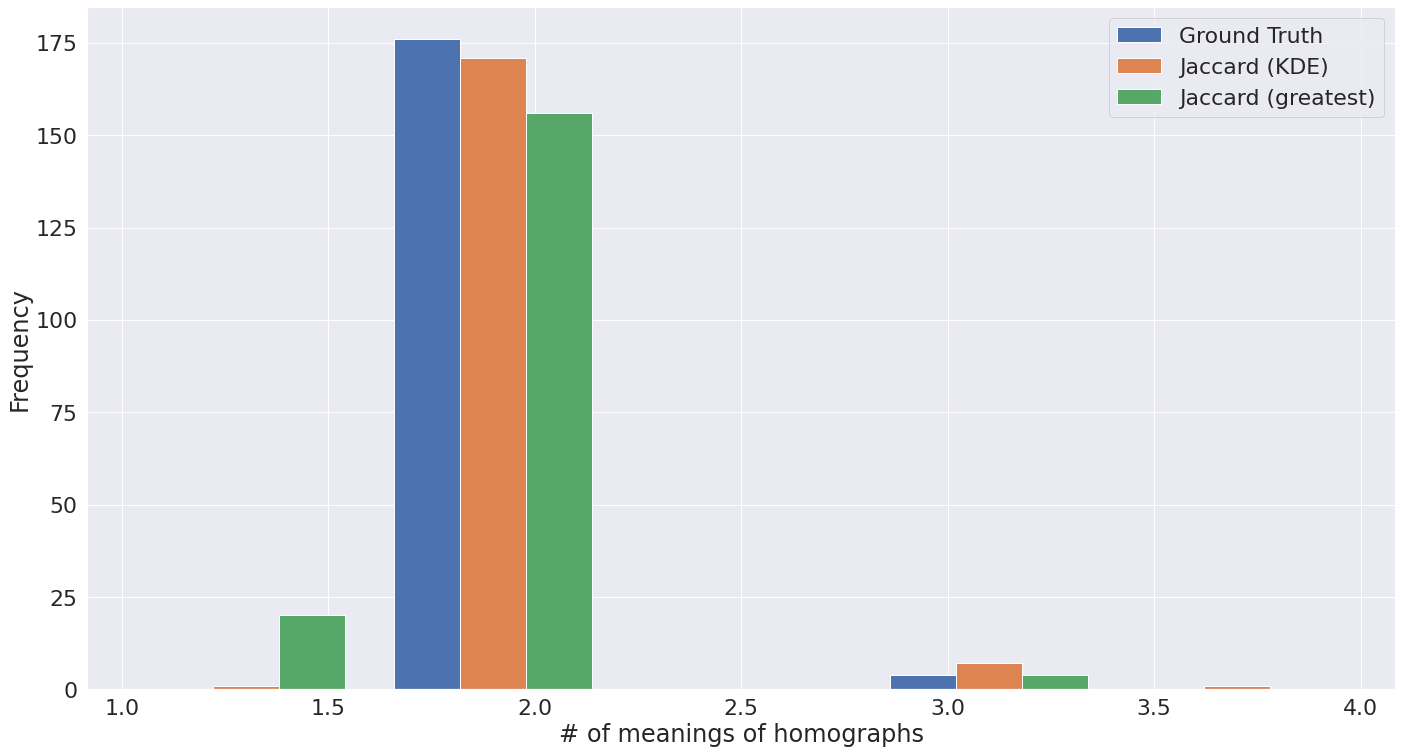

In [105]:
ax = plt.hist([df_input_nodes['num_meanings_groundtruth'], df_input_nodes['num_meanings_kde'], df_input_nodes['num_meanings_greatest']], bins=5, label=['Ground Truth', 'Jaccard (KDE)', 'Jaccard (greatest)'])
plt.xlabel('# of meanings of homographs');plt.ylabel('Frequency');plt.legend();plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/num_meanings_histogram.svg')

In [106]:
df_input_nodes[df_input_nodes['is_kde_num_meanings_correct'] == False]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct,greatest_adj_rand_index,greatest_adj_mutual_info,greatest_norm_mutual_info,kde_adj_rand_index,kde_adj_mutual_info,kde_norm_mutual_info
300,Lincoln,cell,0.004879,True,8.0,3,3.0,4.0,0.983322,0.623339,False,False,True,1.0,1.0,1.0,0.740741,7.672359e-01,0.880421
24153,Darcy,cell,0.001545,True,23.0,2,2.0,1.0,0.988259,0.997867,False,False,True,1.0,1.0,1.0,0.000000,4.651263e-16,0.000000
1174,Chicago,cell,0.001432,True,27.0,2,2.0,3.0,0.978523,0.589618,False,False,True,1.0,1.0,1.0,0.571429,5.714286e-01,0.800000
590,Brooklyn,cell,0.001227,True,31.0,2,2.0,3.0,0.983322,0.589633,False,False,True,1.0,1.0,1.0,0.333333,4.206198e-01,0.702017
723,Jamaica,cell,0.001169,True,33.0,2,2.0,3.0,0.981066,0.841035,False,False,True,1.0,1.0,1.0,0.974766,8.786539e-01,0.894711
18618,Kansas,cell,0.000264,True,80.0,2,2.0,3.0,0.978523,0.199021,False,False,True,1.0,1.0,1.0,0.782609,7.125940e-01,0.829199


## Number of Samples Experiment

In [107]:
samples_to_df_dict = {}

for samples in tqdm(range(200, 10000, 100)):
    df_tmp = df.copy()[df['node'].isin(input_nodes)]
    df_tmp, labels_greatest_tmp, labels_kde_tmp = get_num_meanings(df_tmp, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=samples, rel_height=0.999, bandwidth_multiplier=20)
    df_tmp = run_cluster_evaluation_df(df_tmp, G, labels_greatest_tmp, labels_kde_tmp, node_to_idx_dict)
    samples_to_df_dict[samples] = df_tmp

100%|██████████| 98/98 [03:09<00:00,  1.94s/it]


In [110]:
samples_to_statistics_dict = {'samples': [], 'precision_kde': [], 'precision_greatest': [], 'greatest_adj_rand_index': [], 'greatest_norm_mutual_info': [], 'kde_adj_rand_index': [], 'kde_norm_mutual_info': []}
for num_samples, df_tmp in samples_to_df_dict.items():
    precision_kde = df_tmp['is_kde_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    precision_greatest = df_tmp['is_greatest_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    samples_to_statistics_dict['samples'].append(num_samples)
    samples_to_statistics_dict['precision_kde'].append(precision_kde)
    samples_to_statistics_dict['precision_greatest'].append(precision_greatest)

    samples_to_statistics_dict['greatest_adj_rand_index'].append(df_tmp['greatest_adj_rand_index'].mean())
    samples_to_statistics_dict['greatest_norm_mutual_info'].append(df_tmp['greatest_norm_mutual_info'].mean())
    samples_to_statistics_dict['kde_adj_rand_index'].append(df_tmp['kde_adj_rand_index'].mean())
    samples_to_statistics_dict['kde_norm_mutual_info'].append(df_tmp['kde_norm_mutual_info'].mean())

samples_to_statistics_df = pd.DataFrame.from_dict(samples_to_statistics_dict)
samples_to_statistics_df.head()

,samples,precision_kde,precision_greatest,greatest_adj_rand_index,greatest_norm_mutual_info,kde_adj_rand_index,kde_norm_mutual_info
0,200,0.950000,0.888889,0.888889,0.888889,0.987437,0.991143
1,300,0.966667,0.888889,0.888889,0.888889,0.985572,0.989480
2,400,0.961111,0.888889,0.888889,0.888889,0.980016,0.983924
3,500,0.961111,0.888889,0.888889,0.888889,0.980016,0.983924
4,600,0.961111,0.888889,0.888889,0.888889,0.980016,0.983924


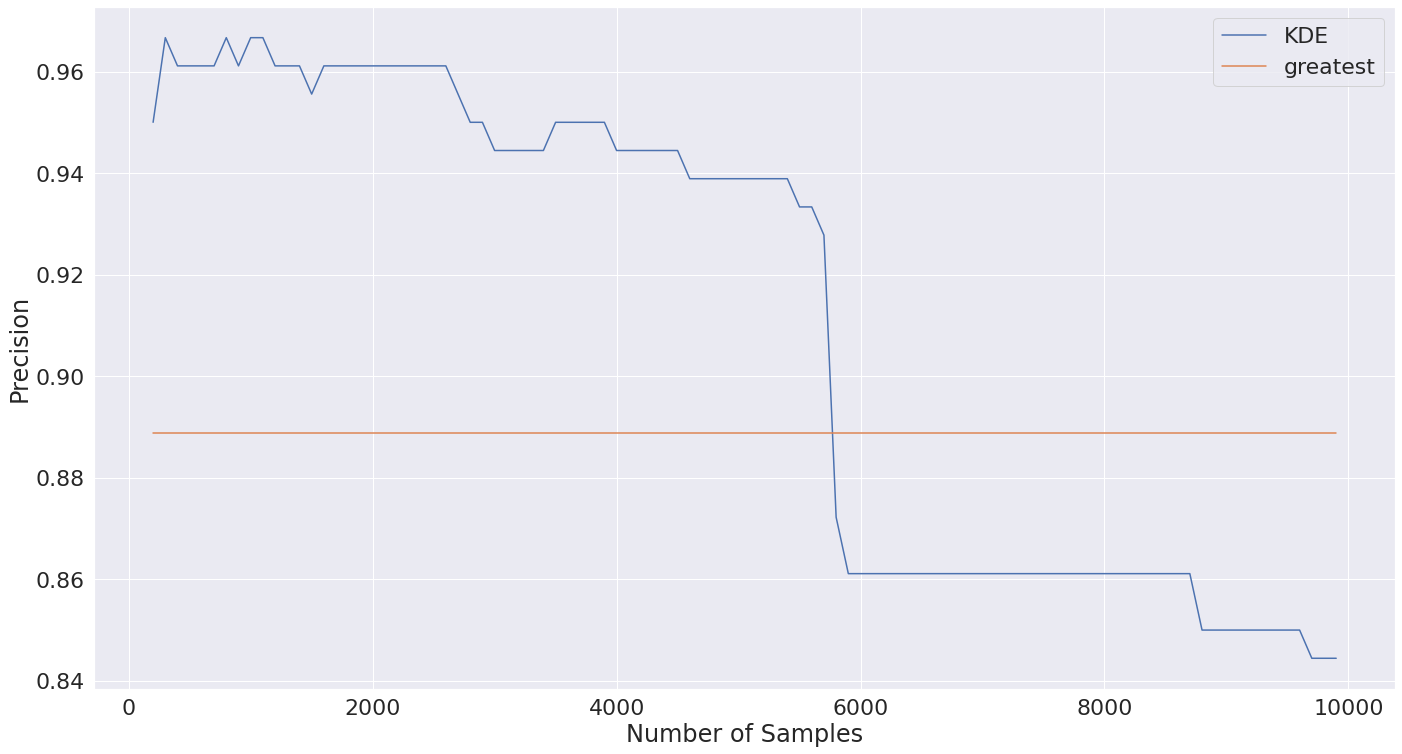

In [109]:
plt.plot(samples_to_statistics_df['samples'], samples_to_statistics_df['precision_kde'], label='KDE')
plt.plot(samples_to_statistics_df['samples'], samples_to_statistics_df['precision_greatest'], label='greatest')
plt.legend();plt.ylabel('Precision');plt.xlabel('Number of Samples');plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/num_samples_precision.svg')

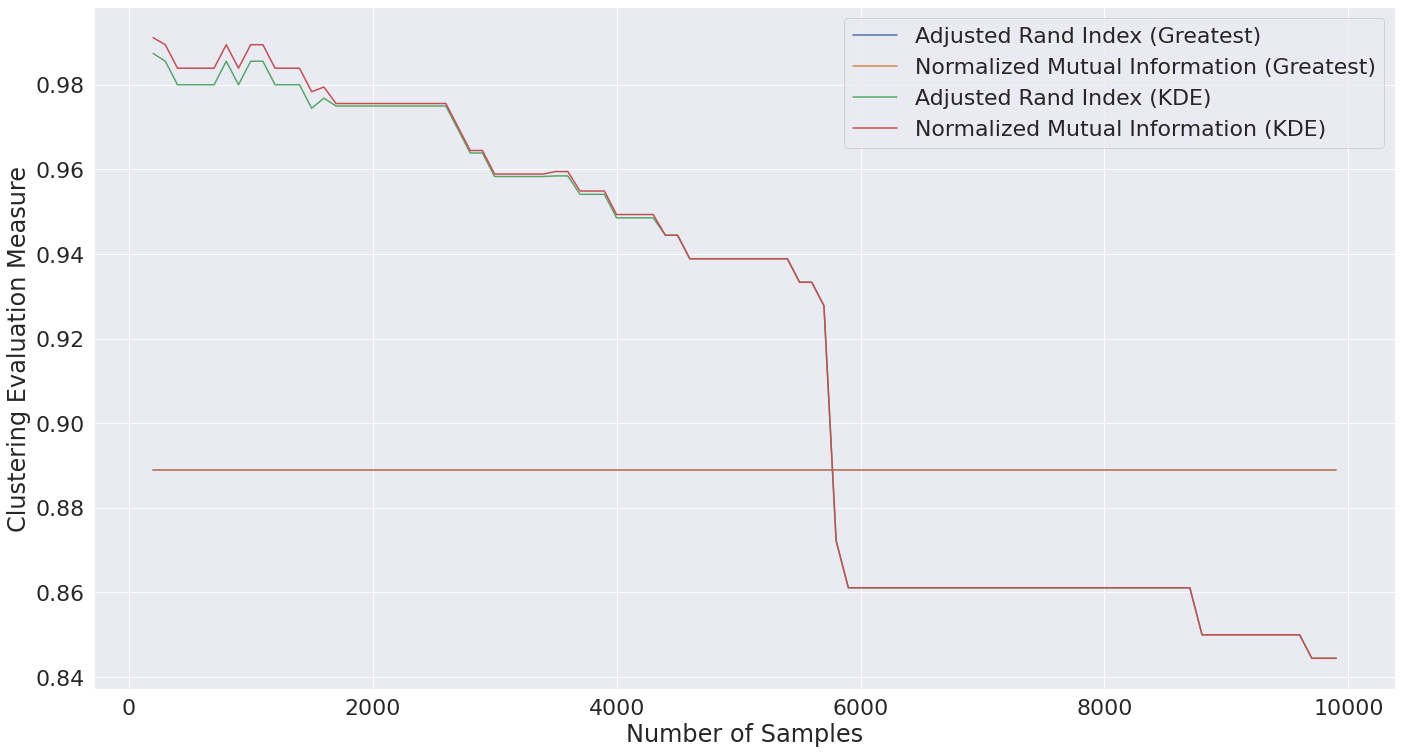

In [113]:
# Evaluate the clustering
plt.plot(samples_to_statistics_df['samples'], samples_to_statistics_df['greatest_adj_rand_index'], label='Adjusted Rand Index (Greatest)')
plt.plot(samples_to_statistics_df['samples'], samples_to_statistics_df['greatest_norm_mutual_info'], label='Normalized Mutual Information (Greatest)')
plt.plot(samples_to_statistics_df['samples'], samples_to_statistics_df['kde_adj_rand_index'], label='Adjusted Rand Index (KDE)')
plt.plot(samples_to_statistics_df['samples'], samples_to_statistics_df['kde_norm_mutual_info'], label='Normalized Mutual Information (KDE)')
plt.legend();plt.ylabel('Clustering Evaluation Measure');plt.xlabel('Number of Samples');plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/clustering_evaluation.svg')

## Relative Height Experiment

In [85]:
rel_height_to_df_dict = {}

for rel_height in tqdm(np.arange(0.97, 1, 0.0005)):
    df_tmp = df.copy()[df['node'].isin(input_nodes)]
    df_tmp = get_num_meanings(df_tmp, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=rel_height, bandwidth_multiplier=20)
    rel_height_to_df_dict[rel_height] = df_tmp

100%|██████████| 61/61 [00:23<00:00,  2.64it/s]


In [86]:
rel_height_to_precision_dict = {'rel_height': [], 'precision_kde': [], 'precision_greatest': []}
for rel_height, df_tmp in rel_height_to_df_dict.items():
    precision_kde = df_tmp['is_kde_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    precision_greatest = df_tmp['is_greatest_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    rel_height_to_precision_dict['rel_height'].append(rel_height)
    rel_height_to_precision_dict['precision_kde'].append(precision_kde)
    rel_height_to_precision_dict['precision_greatest'].append(precision_greatest)

rel_height_to_precision_df = pd.DataFrame.from_dict(rel_height_to_precision_dict)
rel_height_to_precision_df.head()

,rel_height,precision_kde,precision_greatest
0,0.9700,0.961111,0.888889
1,0.9705,0.961111,0.888889
2,0.9710,0.961111,0.888889
3,0.9715,0.961111,0.888889
4,0.9720,0.961111,0.888889


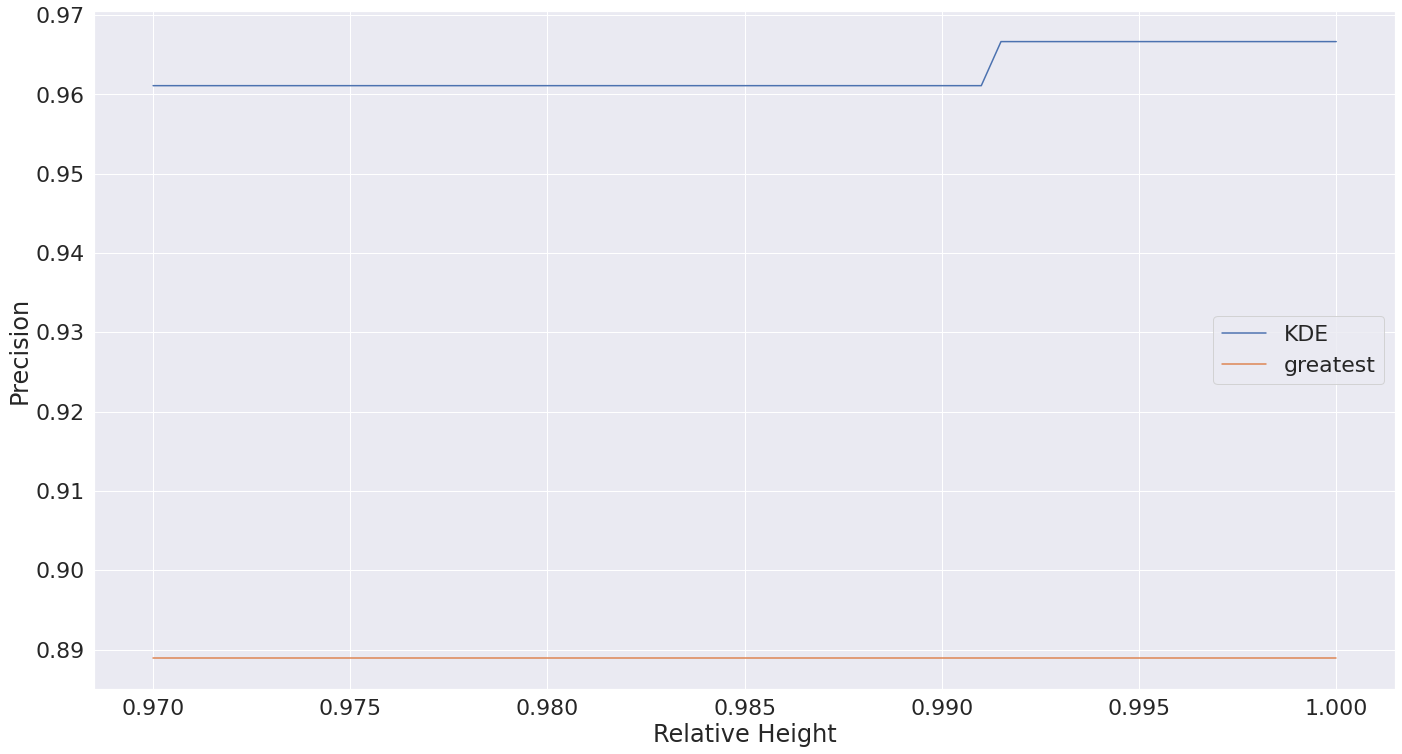

In [88]:
plt.plot(rel_height_to_precision_df['rel_height'], rel_height_to_precision_df['precision_kde'], label='KDE')
plt.plot(rel_height_to_precision_df['rel_height'], rel_height_to_precision_df['precision_greatest'], label='greatest')
plt.legend();plt.ylabel('Precision');plt.xlabel('Relative Height');plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/rel_height_precision.svg')

# Jaccard Similarity (Synthetic Dataset with Nulls)

In [89]:
df_path = '../../output/synthetic_example_large_with_nulls/'
g_path = '../../../graph_construction/combined_graphs_output/synthetic_benchmark_large_with_nulls/bipartite/bipartite.graph'
input_nodes_json_path = '../../input/synthetic_large_with_nulls/input_nodes.json'
matrices_path = df_path + 'num_meanings/jaccard/matrices/'

df = pd.read_pickle(df_path + 'graph_stats_with_groundtruth_df.pickle')
G = pickle.load(open(g_path, "rb"))

with open(input_nodes_json_path) as f:
  input_nodes = json.load(f)['input_nodes']

# Remove nodes with degree 1 from the dataframe
df = stp.process_df(df, G)

# Compute the groundtruth for the number of meanings for each homograph
df = utils.num_meanings.get_num_meanings_groundtruth(df, G)
df_homs = df[df['is_homograph']==True].sort_values(by='betweenness_centrality', ascending=False)
df_homs

100%|██████████| 183/183 [00:00<00:00, 4324.95it/s]

There are 6503 cell nodes with a degree greater than 1
There are 614 unique ranks based on BC.


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
70,missing,cell,1.611175e-01,True,1.0,17
2059,unknown,cell,1.244477e-01,True,2.0,11
2815,undefined,cell,1.045398e-02,True,3.0,8
723,Jamaica,cell,3.296411e-03,True,4.0,2
7589,Palm,cell,3.005904e-03,True,5.0,2
...,...,...,...,...,...,...
27428,Comanche,cell,1.487889e-05,True,213.0,2
2004,ME,cell,1.108179e-05,True,219.0,2
1959,California,cell,5.439775e-06,True,267.0,2
1945,LA,cell,5.320422e-06,True,272.0,2


In [90]:
df_homs[df_homs['num_meanings_groundtruth'] > 2]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
70,missing,cell,0.161117,True,1.0,17
2059,unknown,cell,0.124448,True,2.0,11
2815,undefined,cell,0.010454,True,3.0,8
546,Virginia,cell,0.000858,True,27.0,3
300,Lincoln,cell,0.000701,True,37.0,3
1401,Aurora,cell,0.000379,True,60.0,3
2012,Montana,cell,0.000299,True,79.0,3


In [91]:
# Map each input node from tje json file to its pairwise distance matrix and its index to node dictionary
node_to_matrix_dict = {}
node_to_idx_dict = {}
for node in input_nodes:
    # We subtract the matrix from one to convert it from a similarity matrix to a distance matrix
    m = 1 - np.load(matrices_path + node + '.npy')
    idx_to_node = pickle.load(open(matrices_path + node + '_idx_to_node.pickle', 'rb'))

    node_to_matrix_dict[node] = m
    node_to_idx_dict[node] = idx_to_node

In [92]:
df_input_nodes = df.copy()[df['node'].isin(input_nodes)]
df_input_nodes = get_num_meanings(df_input_nodes, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=0.999, bandwidth_multiplier=20)
df_input_nodes

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct
70,missing,cell,1.611175e-01,True,1.0,17,17.0,22.0,0.989247,0.870269,False,False,True
2059,unknown,cell,1.244477e-01,True,2.0,11,12.0,13.0,0.969828,0.697409,False,False,False
2815,undefined,cell,1.045398e-02,True,3.0,8,8.0,8.0,0.605505,0.640180,False,True,True
723,Jamaica,cell,3.296411e-03,True,4.0,2,2.0,3.0,0.980365,0.839744,False,False,True
7589,Palm,cell,3.005904e-03,True,5.0,2,2.0,2.0,0.970414,0.973101,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27428,Comanche,cell,1.487889e-05,True,213.0,2,2.0,2.0,0.010000,0.992154,False,True,True
2004,ME,cell,1.108179e-05,True,219.0,2,1.0,2.0,0.907895,0.440032,False,True,False
1959,California,cell,5.439775e-06,True,267.0,2,2.0,2.0,0.291667,0.366605,False,True,True
1945,LA,cell,5.320422e-06,True,272.0,2,1.0,2.0,0.922078,0.352817,False,True,False


In [93]:
print('Greatest distribution:', df_input_nodes['is_greatest_num_meanings_correct'].value_counts())
print('KDE distribution:', df_input_nodes['is_kde_num_meanings_correct'].value_counts())

Greatest distribution: True     161
False     22
Name: is_greatest_num_meanings_correct, dtype: int64
KDE distribution: True     174
False      9
Name: is_kde_num_meanings_correct, dtype: int64


In [95]:
df_input_nodes[df_input_nodes['is_kde_num_meanings_correct'] == False]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct
70,missing,cell,0.161117,True,1.0,17,17.0,22.0,0.989247,0.870269,False,False,True
2059,unknown,cell,0.124448,True,2.0,11,12.0,13.0,0.969828,0.697409,False,False,False
723,Jamaica,cell,0.003296,True,4.0,2,2.0,3.0,0.980365,0.839744,False,False,True
590,Brooklyn,cell,0.001276,True,17.0,2,2.0,3.0,0.982627,0.588885,False,False,True
24144,Darcy,cell,0.001016,True,21.0,2,2.0,1.0,0.988265,0.997348,False,False,True
1174,Chicago,cell,0.000921,True,24.0,2,2.0,3.0,0.978534,0.588870,False,False,True
300,Lincoln,cell,0.000701,True,37.0,3,3.0,4.0,0.982627,0.622526,False,False,True
275,Elmira,cell,0.000280,True,87.0,2,2.0,1.0,0.982627,0.999801,False,False,True
18611,Kansas,cell,0.000234,True,94.0,2,2.0,3.0,0.978534,0.216623,False,False,True


## Number of Samples Experiment

In [96]:
samples_to_df_dict = {}

for samples in tqdm(range(200, 10000, 100)):
    df_tmp = df.copy()[df['node'].isin(input_nodes)]
    df_tmp = get_num_meanings(df_tmp, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=samples, rel_height=0.999, bandwidth_multiplier=20)
    samples_to_df_dict[samples] = df_tmp

100%|██████████| 98/98 [01:14<00:00,  1.32it/s]


In [101]:
samples_to_precision_dict = {'samples': [], 'precision_kde': [], 'precision_greatest': []}
for num_samples, df_tmp in samples_to_df_dict.items():
    precision_kde = df_tmp['is_kde_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    precision_greatest = df_tmp['is_greatest_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    samples_to_precision_dict['samples'].append(num_samples)
    samples_to_precision_dict['precision_kde'].append(precision_kde)
    samples_to_precision_dict['precision_greatest'].append(precision_greatest)

samples_to_precision_df = pd.DataFrame.from_dict(samples_to_precision_dict)
samples_to_precision_df.head()

,samples,precision_kde,precision_greatest
0,200,0.934426,0.879781
1,300,0.950820,0.879781
2,400,0.950820,0.879781
3,500,0.950820,0.879781
4,600,0.950820,0.879781


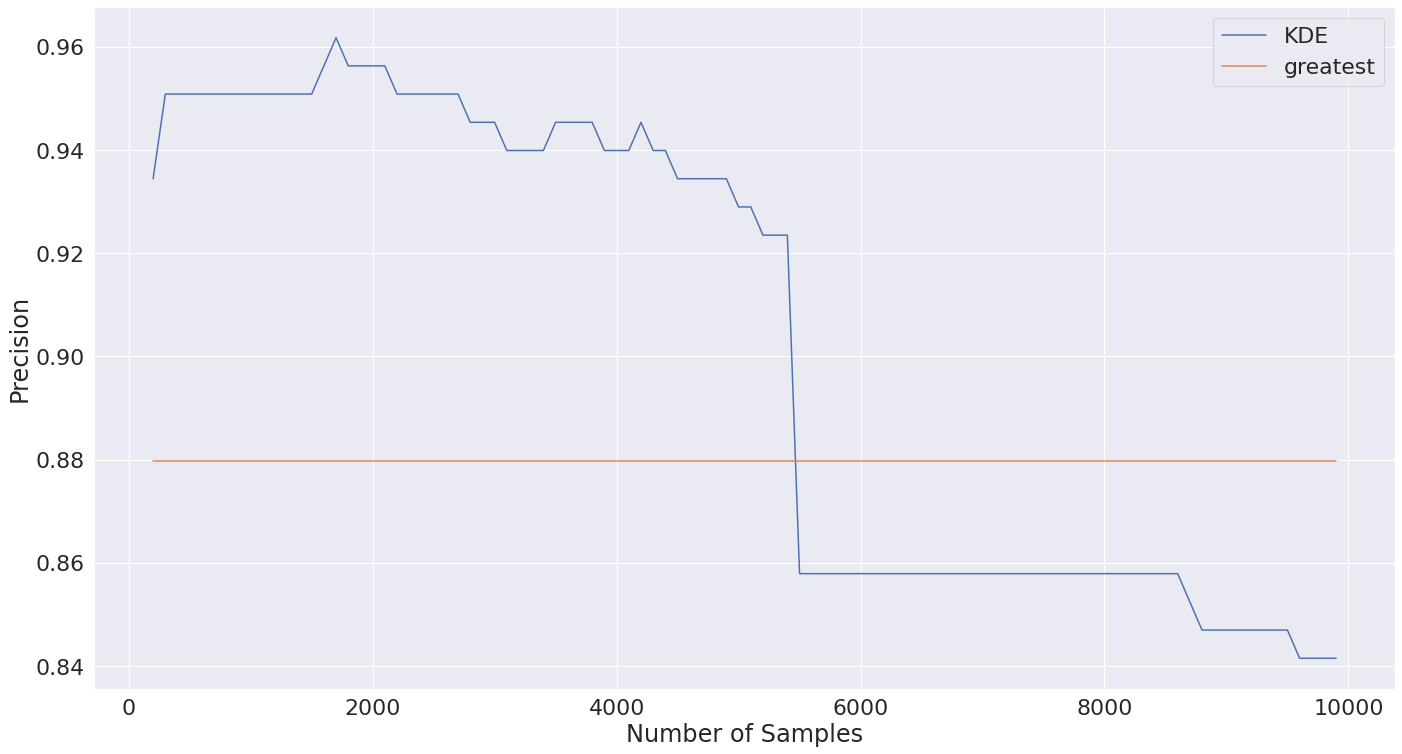

In [102]:
plt.plot(samples_to_precision_df['samples'], samples_to_precision_df['precision_kde'], label='KDE')
plt.plot(samples_to_precision_df['samples'], samples_to_precision_df['precision_greatest'], label='greatest')
plt.legend();plt.ylabel('Precision');plt.xlabel('Number of Samples');plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark_with_nulls/num_samples_precision.svg')

# Unionability (Synthetic Dataset)

In [138]:
df_path = '../../output/synthetic_example_large/'
g_path = '../../../graph_construction/combined_graphs_output/synthetic_benchmark_large/bipartite/bipartite.graph'
input_nodes_json_path = '../../input/synthetic_large/input_nodes.json'
matrices_path = df_path + 'num_meanings/unionability/matrices/'

df = pd.read_pickle(df_path + 'graph_stats_with_groundtruth_df.pickle')
G = pickle.load(open(g_path, "rb"))

with open(input_nodes_json_path) as f:
  input_nodes = json.load(f)['input_nodes']

# Remove nodes with degree 1 from the dataframe
df = stp.process_df(df, G)

# Compute the groundtruth for the number of meanings for each homograph
df = utils.num_meanings.get_num_meanings_groundtruth(df, G)
df_homs = df[df['is_homograph']==True].sort_values(by='betweenness_centrality', ascending=False)
df_homs

100%|██████████| 180/180 [00:00<00:00, 4223.94it/s]

There are 6502 cell nodes with a degree greater than 1
There are 611 unique ranks based on BC.


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
7590,Palm,cell,1.445700e-02,True,1.0,2
25825,Clementine,cell,8.975958e-03,True,2.0,2
7130,Magnolia,cell,8.132084e-03,True,3.0,2
3077,Jaguar,cell,8.049376e-03,True,4.0,2
7416,Timothy,cell,6.921700e-03,True,5.0,2
...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2
1828,SD,cell,2.059766e-07,True,276.0,2
2004,ME,cell,1.214843e-07,True,314.0,2
1950,NC,cell,7.969017e-08,True,329.0,2


In [139]:
# Map each input node from tje json file to its pairwise distance matrix and its index to node dictionary
node_to_matrix_dict = {}
node_to_idx_dict = {}
for node in input_nodes:
    # We subtract the matrix from one to convert it from a similarity matrix to a distance matrix
    m = 1 - np.load(matrices_path + node + '.npy')
    idx_to_node = pickle.load(open(matrices_path + node + '_idx_to_node.pickle', 'rb'))

    node_to_matrix_dict[node] = m
    node_to_idx_dict[node] = idx_to_node

In [140]:
df_input_nodes = df.copy()[df['node'].isin(input_nodes)]
df_input_nodes, labels_greatest, labels_kde = get_num_meanings(df_input_nodes, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=0.999, bandwidth_multiplier=20)
df_input_nodes = run_cluster_evaluation_df(df_input_nodes, G, labels_greatest, labels_kde, node_to_idx_dict)
df_input_nodes

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct,greatest_adj_rand_index,greatest_adj_mutual_info,greatest_norm_mutual_info,kde_adj_rand_index,kde_adj_mutual_info,kde_norm_mutual_info
7590,Palm,cell,1.445700e-02,True,1.0,2,1.0,1.0,0.833333,0.544343,False,False,False,0.0,0.000000e+00,0.00000,0.0,0.000000e+00,0.00000
25825,Clementine,cell,8.975958e-03,True,2.0,2,2.0,2.0,0.010000,0.500000,False,True,True,1.0,1.000000e+00,1.00000,1.0,1.000000e+00,1.00000
7130,Magnolia,cell,8.132084e-03,True,3.0,2,2.0,2.0,NaN,NaN,True,True,True,1.0,0.000000e+00,1.00000,1.0,0.000000e+00,1.00000
3077,Jaguar,cell,8.049376e-03,True,4.0,2,1.0,1.0,0.933333,0.803534,False,False,False,0.0,6.406853e-16,0.00000,0.0,6.406853e-16,0.00000
7416,Timothy,cell,6.921700e-03,True,5.0,2,2.0,2.0,NaN,NaN,True,True,True,1.0,0.000000e+00,1.00000,1.0,0.000000e+00,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2,6.0,6.0,0.010000,0.500000,False,False,False,0.0,6.622275e-16,0.40187,0.0,6.622275e-16,0.40187
1828,SD,cell,2.059766e-07,True,276.0,2,6.0,6.0,0.010000,0.500000,False,False,False,0.0,6.622275e-16,0.40187,0.0,6.622275e-16,0.40187
2004,ME,cell,1.214843e-07,True,314.0,2,4.0,4.0,0.010000,0.500000,False,False,False,0.0,2.694849e-16,0.57716,0.0,2.694849e-16,0.57716
1950,NC,cell,7.969017e-08,True,329.0,2,3.0,3.0,0.010000,0.500000,False,False,False,0.0,4.805140e-16,0.73368,0.0,4.805140e-16,0.73368


In [141]:
print('Greatest distribution:', df_input_nodes['is_greatest_num_meanings_correct'].value_counts())
print('KDE distribution:', df_input_nodes['is_kde_num_meanings_correct'].value_counts())

Greatest distribution: True     96
False    84
Name: is_greatest_num_meanings_correct, dtype: int64
KDE distribution: True     101
False     79
Name: is_kde_num_meanings_correct, dtype: int64


In [142]:
df_input_nodes[df_input_nodes['is_trivial_prediction'] == False].mean()

betweenness_centrality                0.000992
is_homograph                          1.000000
dense_rank                          106.107843
num_meanings_groundtruth              2.039216
num_meanings_greatest                 3.460784
num_meanings_kde                      3.833333
epsilon_greatest                      0.352978
epsilon_kde                           0.571409
is_trivial_prediction                 0.000000
is_kde_num_meanings_correct           0.225490
is_greatest_num_meanings_correct      0.176471
greatest_adj_rand_index               0.068805
greatest_adj_mutual_info              0.066536
greatest_norm_mutual_info             0.341354
kde_adj_rand_index                    0.155057
kde_adj_mutual_info                   0.150644
kde_norm_mutual_info                  0.518757
dtype: float64

# Testing

In [122]:
node = 'Jamaica'
print(node_to_idx_dict[node])
node_to_matrix_dict[node]

{0: 'city_location_city_country_1.csv', 1: 'city_location_city_country_2.csv', 2: 'country_location_city_country_1.csv', 3: 'country_location_country_country_code_1.csv', 4: 'country_location_country_country_code_2.csv', 5: 'country_nature_animal_name_scientific_name_country_1.csv', 6: 'country_nature_animal_name_scientific_name_country_2.csv', 7: 'country_nature_plant_name_scientific_name_family_country_1.csv', 8: 'country_nature_plant_name_scientific_name_family_country_2.csv', 9: 'country_nature_plant_name_scientific_name_family_country_3.csv', 10: 'country_personal_company_name_full_name_country_1.csv', 11: 'country_personal_company_name_full_name_country_2.csv', 12: 'country_personal_company_name_full_name_country_3.csv', 13: 'country_product_grocery_country_1.csv', 14: 'country_product_grocery_country_2.csv'}


array([[0.        , 0.98036466, 0.99908925, 0.99817017, 0.99909091,
        0.99908088, 0.99909584, 0.99908925, 0.99908592, 0.99908088,
        0.99908759, 0.99909256, 0.99909502, 0.99909091, 0.99816682],
       [0.98036466, 0.        , 0.99834983, 0.99667221, 0.99835526,
        0.99832215, 0.99837134, 0.99834983, 0.99833887, 0.99832215,
        0.99834437, 0.99836066, 0.99836868, 0.99835526, 0.9966611 ],
       [0.99908925, 0.99834983, 0.        , 0.35761589, 0.37179487,
        0.38666667, 0.36477987, 0.39490446, 0.43037975, 0.37583893,
        0.31081081, 0.38993711, 0.41104294, 0.38216561, 0.4025974 ],
       [0.99817017, 0.99667221, 0.35761589, 0.        , 0.33333333,
        0.36986301, 0.37974684, 0.41025641, 0.31724138, 0.41333333,
        0.39215686, 0.37419355, 0.34415584, 0.35526316, 0.37583893],
       [0.99909091, 0.99835526, 0.37179487, 0.33333333, 0.        ,
        0.38410596, 0.34177215, 0.38216561, 0.33333333, 0.39473684,
        0.40506329, 0.36708861, 0.36875   , 

Vals: [0.999474513925381, 0.9994756161510225, 0.9994761655316919, 0.999474513925381, 0.9698275862068966, 0.9704142011834319, 0.9994756161510225, 0.9698275862068966, 0.9677072120559742, 0.9994761655316919, 0.9704142011834319, 0.9677072120559742]
[0.00198039 0.00493447 0.00226663] [1.25425583 0.27457732 0.65396808] [0.96672673 0.96659168 0.99832799] [0.96870713 0.97152615 1.00059462]
Epsilon: 1.000594621879016


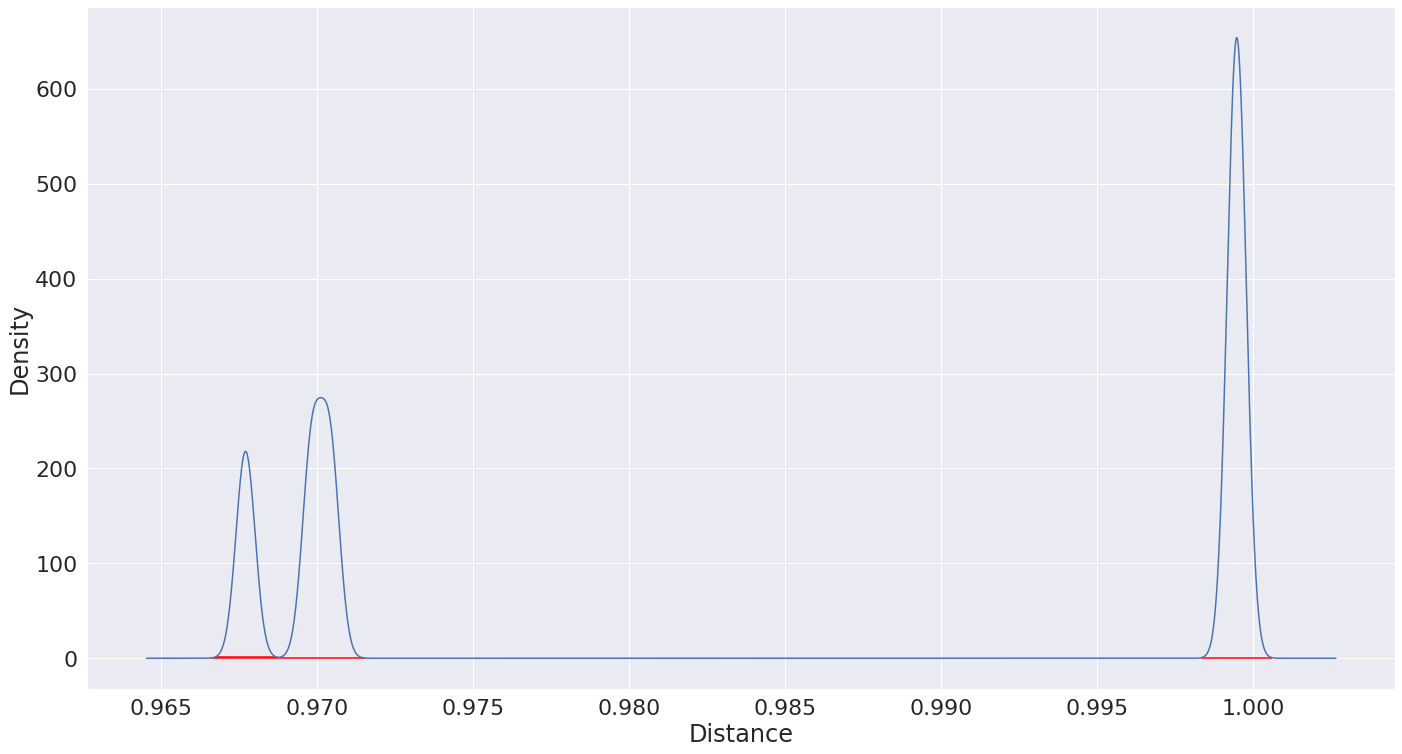

In [121]:
num_samples=2500
vals = get_vals_in_range(node_to_matrix_dict[node], lower_bound=0, upper_bound=1)
print('Vals:', vals)

density, samples, lower_bnd, upper_bnd = get_kde(vals, bandwidth_multiplier=20, num_samples=num_samples)

widths, width_heights, left_pos, right_pos = get_peak_widths(density, lower_bnd, upper_bnd, num_samples=num_samples, rel_height=0.999)
print(widths, width_heights, left_pos, right_pos)

epsilon = max(right_pos)
print('Epsilon:', epsilon)

plt.plot(samples, density)
plt.hlines(y=width_heights, xmin=left_pos, xmax=right_pos, colors='red')
plt.xlabel('Distance');plt.ylabel('Density');plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/palm_example_2500_samples.svg')

In [251]:
epsilon = get_epsilon(node_to_matrix_dict[node], lower_bound=0, upper_bound=1, mode='kde', num_samples=1000, rel_height=0.999, bandwidth_multiplier=20)
epsilon

0.8410352614617482

In [256]:
labels = DBSCAN(min_samples=1, metric='precomputed', eps=0.99).fit_predict(node_to_matrix_dict[node])
print(node_to_idx_dict[node])
print(labels)

{0: 'city_location_city_country_1.csv', 1: 'city_location_city_country_2.csv', 2: 'country_location_city_country_1.csv', 3: 'country_location_country_country_code_1.csv', 4: 'country_location_country_country_code_2.csv', 5: 'country_nature_animal_name_scientific_name_country_1.csv', 6: 'country_nature_animal_name_scientific_name_country_2.csv', 7: 'country_nature_plant_name_scientific_name_family_country_1.csv', 8: 'country_nature_plant_name_scientific_name_family_country_2.csv', 9: 'country_nature_plant_name_scientific_name_family_country_3.csv', 10: 'country_personal_company_name_full_name_country_1.csv', 11: 'country_personal_company_name_full_name_country_2.csv', 12: 'country_personal_company_name_full_name_country_3.csv', 13: 'country_product_grocery_country_1.csv', 14: 'country_product_grocery_country_2.csv'}
[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
